In [2]:
!pip install yfinance
!pip install pmdarima
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from prophet import Prophet

In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Data Collection and Preprocessing

In [5]:
# Define stock symbol and date range
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-02-14'

# Fetch data
data = yf.download(symbol, start=start_date, end=end_date)
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])

# Display first few rows
print("Dataset Shape:", data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed

Dataset Shape: (1036, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2020-01-02,72.716080,72.776606,71.466820,71.721026,135480400
1,2020-01-03,72.009125,72.771752,71.783969,71.941336,146322800
2,2020-01-06,72.582909,72.621646,70.876075,71.127866,118387200
3,2020-01-07,72.241562,72.849239,72.021246,72.592609,108872000
4,2020-01-08,73.403656,73.706287,71.943766,71.943766,132079200


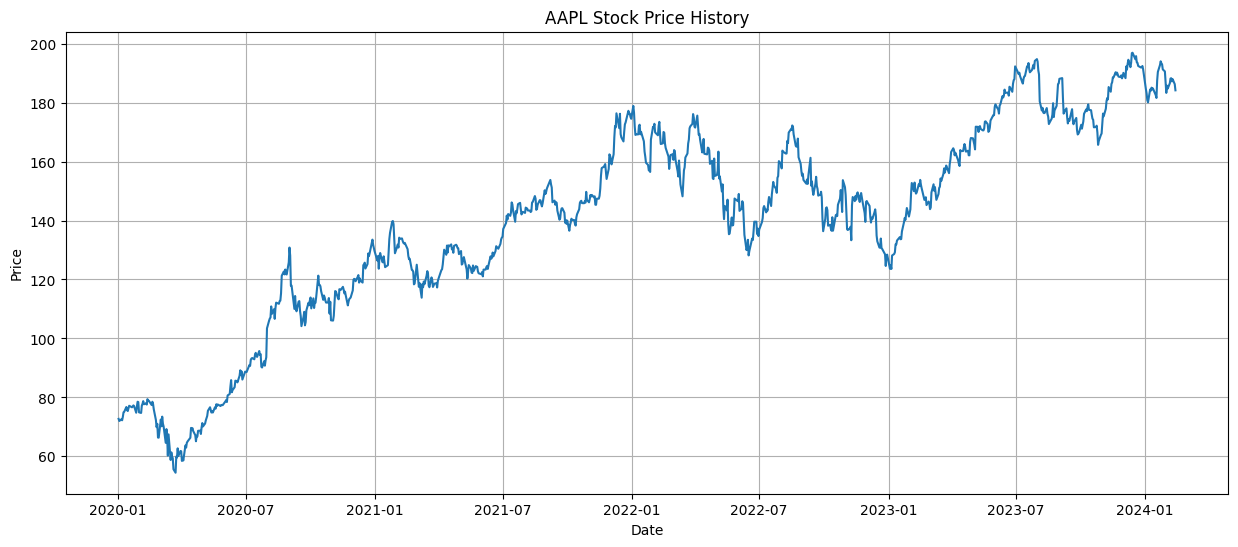

In [6]:
# Visualize the stock prices
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Close'])
plt.title(f'{symbol} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [7]:
def prepare_lstm_data(data, sequence_length=60):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

In [8]:
# Prepare data for LSTM
X_train, X_test, y_train, y_test, scaler = prepare_lstm_data(data)

In [9]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.1251 - val_loss: 0.0077
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0098 - val_loss: 0.0019
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 0.0058 - val_loss: 0.0027
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0049 - val_loss: 8.3410e-04
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0056 - val_loss: 0.0010
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step -

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcajpkwdh/t4ow4d9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcajpkwdh/aei7zchm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15583', 'data', 'file=/tmp/tmpcajpkwdh/t4ow4d9r.json', 'init=/tmp/tmpcajpkwdh/aei7zchm.json', 'output', 'file=/tmp/tmpcajpkwdh/prophet_modelikrhzurz/prophet_model-20250214104754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:47:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:47:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1500x600 with 0 Axes>

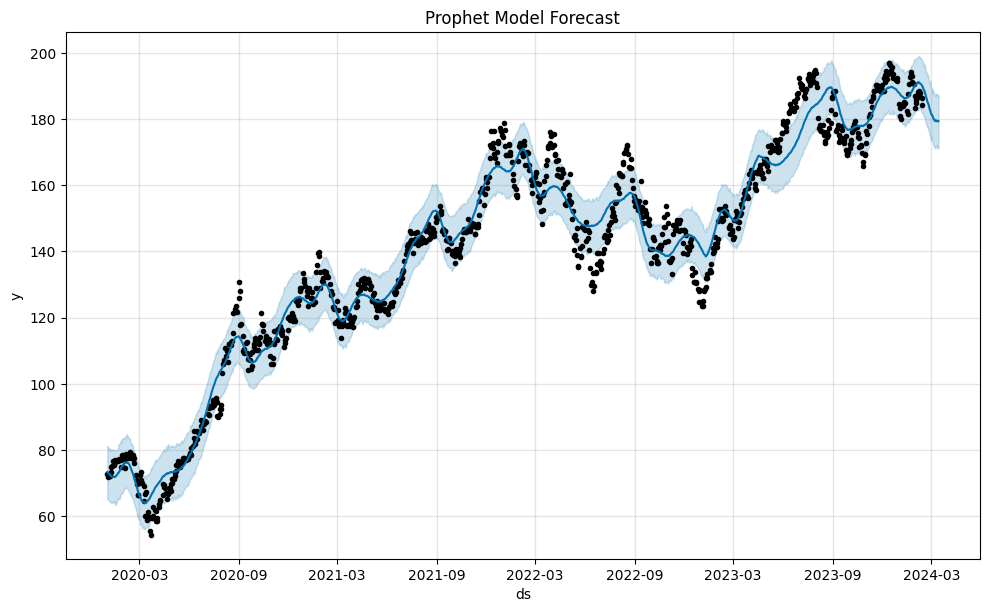


Forecast for the next 30 days:
             ds        yhat  yhat_lower  yhat_upper
1061 2024-03-10  179.496753  172.063923  187.468984
1062 2024-03-11  179.331517  171.331671  187.349325
1063 2024-03-12  179.256786  171.106058  187.037975
1064 2024-03-13  179.401025  171.870625  187.501166
1065 2024-03-14  179.340625  171.080146  187.353037


In [20]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = pd.to_datetime(data['Date'])
df_prophet['y'] = data['Close'].astype(float)

# Handle missing or infinite values
df_prophet.replace([np.inf, -np.inf], np.nan, inplace=True)
df_prophet.dropna(inplace=True)

# Create and train Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet)

# Make future predictions
future_dates = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future_dates)

# Visualize Prophet predictions
plt.figure(figsize=(15, 6))
prophet_model.plot(forecast)
plt.title('Prophet Model Forecast')
plt.show()

# Print some forecast metrics
print("\nForecast for the next 30 days:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [21]:
# Train ARIMA model
arima_model = auto_arima(
    data['Close'],
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Make predictions
n_periods = 30
arima_forecast = arima_model.predict(n_periods=n_periods)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.91 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5605.671, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5310.668, Time=0.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5606.023, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5175.614, Time=1.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=13.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=6.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5175.017, Time=0.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5311.166, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=14.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5175.552, Time=1.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5177.338, Time=4.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5177.010, Time=2.83 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 59.704 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step


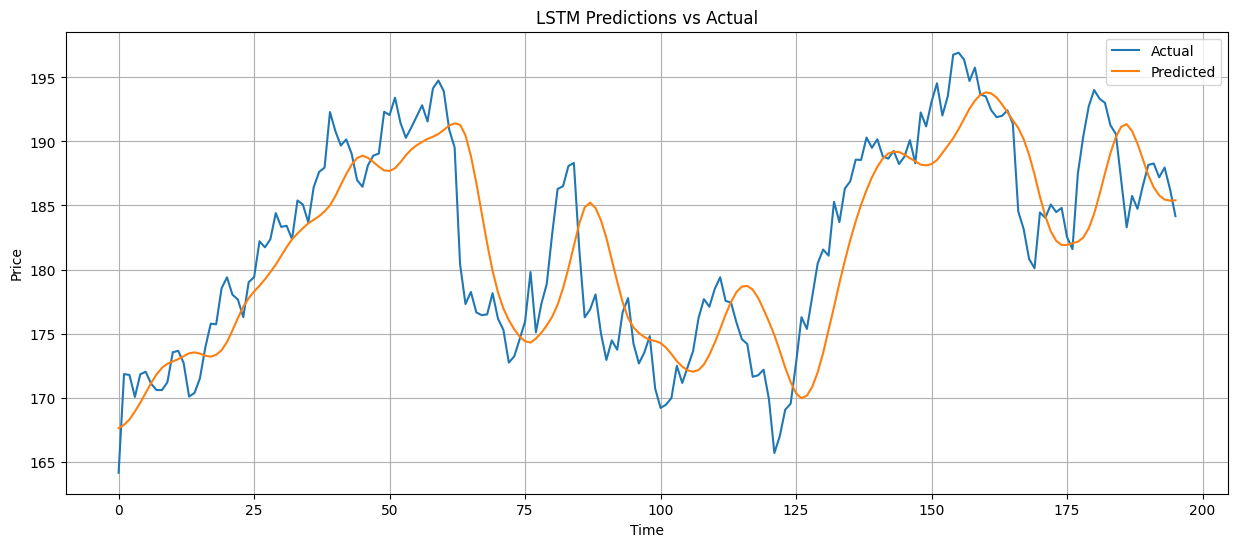

<Figure size 1500x600 with 0 Axes>

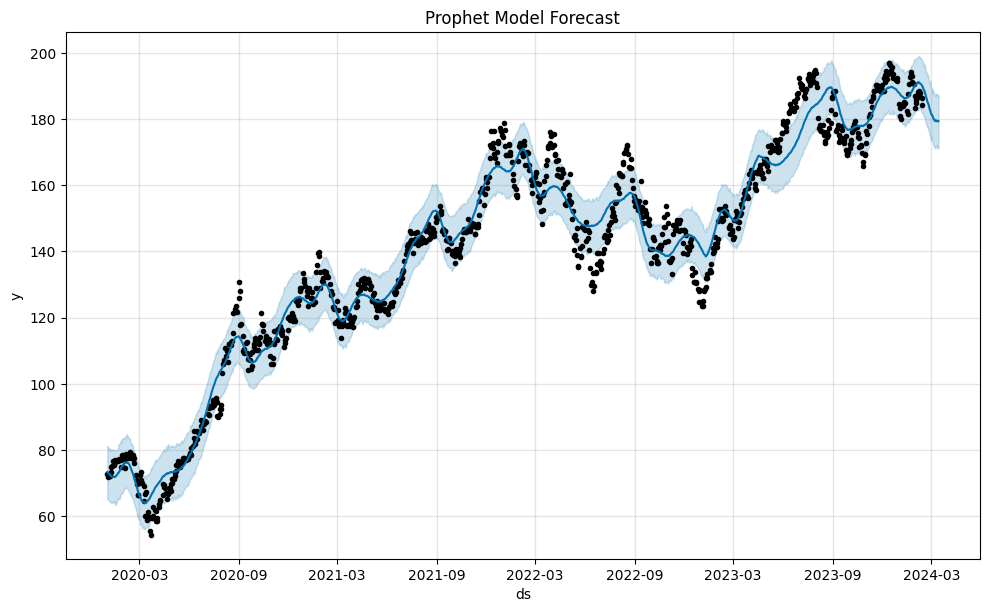

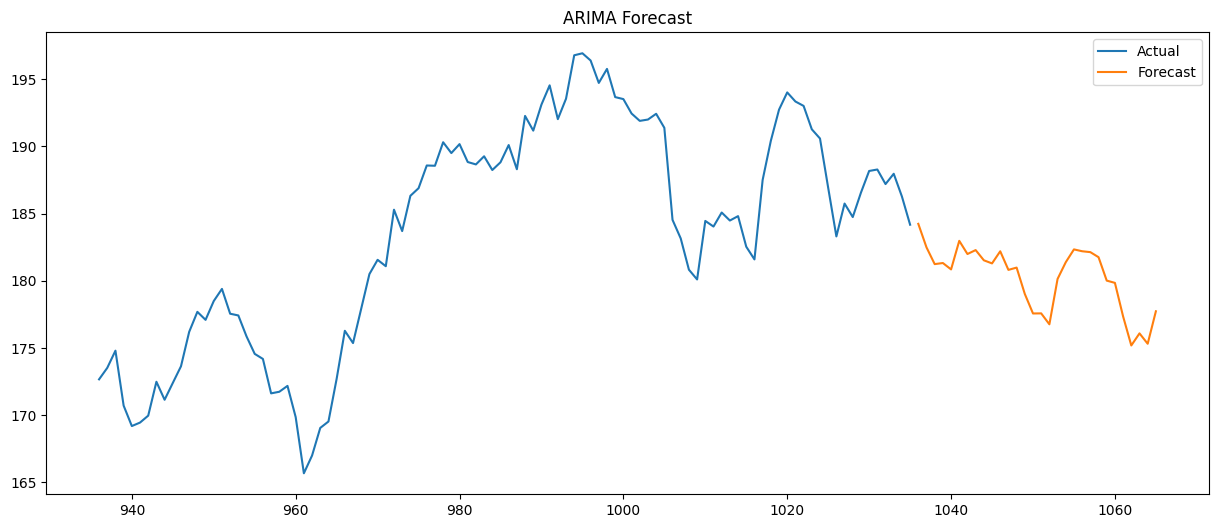

In [22]:
# Visualize results
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(15, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot LSTM predictions
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
actual_prices = scaler.inverse_transform([y_test])
plot_predictions(actual_prices[0], lstm_predictions, 'LSTM Predictions vs Actual')

# Plot Prophet predictions
plt.figure(figsize=(15, 6))
prophet_model.plot(forecast)
plt.title('Prophet Model Forecast')
plt.show()

# Plot ARIMA predictions
plt.figure(figsize=(15, 6))
plt.plot(data.index[-100:], data['Close'].tail(100), label='Actual')
plt.plot(range(len(data), len(data) + n_periods), arima_forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [23]:
# Calculate LSTM performance metrics
lstm_mse = mean_squared_error(actual_prices[0], lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(actual_prices[0], lstm_predictions)

print("LSTM Performance Metrics:")
print(f"MSE: {lstm_mse:.2f}")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAE: {lstm_mae:.2f}")

LSTM Performance Metrics:
MSE: 19.79
RMSE: 4.45
MAE: 3.51


In [24]:
# Prophet performance metrics
prophet_mse = mean_squared_error(data['Close'].tail(30), forecast['yhat'][-30:])
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(data['Close'].tail(30), forecast['yhat'][-30:])

print("Prophet Performance Metrics:")
print(f"MSE: {prophet_mse:.2f}")
print(f"RMSE: {prophet_rmse:.2f}")
print(f"MAE: {prophet_mae:.2f}")

Prophet Performance Metrics:
MSE: 50.72
RMSE: 7.12
MAE: 6.42


In [25]:
# ARIMA performance metrics
arima_mse = mean_squared_error(data['Close'].tail(30), arima_forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(data['Close'].tail(30), arima_forecast)

print("ARIMA Performance Metrics:")
print(f"MSE: {arima_mse:.2f}")
print(f"RMSE: {arima_rmse:.2f}")
print(f"MAE: {arima_mae:.2f}")

ARIMA Performance Metrics:
MSE: 69.33
RMSE: 8.33
MAE: 6.52
